In [1]:
import gym
from gym.envs.registration import register
import numpy as np
# from mdptoolbox import mdp
from hiive.mdptoolbox import mdp
from IPython.display import clear_output
import time
import random
import matplotlib.pyplot as plt

# FrozenLake 4x4

In [2]:
np.random.seed(0)

In [3]:
## render
def render_policy(policy, name, holes, NUM_COLS=4, NUM_ROWS=4):
#     NUM_COLS = 4
#     NUM_ROWS = 4
    directions = ['<', 'v', '>', '^']
    print(name)
#     policy = pi.policy

    visualize_policy = [[' ' for col in range(NUM_COLS)] for row in range(NUM_ROWS)]

    for idx, p in enumerate(policy):
        r = idx//NUM_COLS
        c = idx%NUM_COLS
        if idx in holes:
            visualize_policy[r][c] = 'H'
        else:
            visualize_policy[r][c] = directions[p]

    # Fill Goal state
    visualize_policy[NUM_ROWS -1][NUM_COLS -1] = 'G'

    for p in visualize_policy:
        print(p)



In [4]:
try:
    register(
        id='FrozenLakeNoSlip-v0',
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery':False},
        max_episode_steps=100,
        reward_threshold=0.78, # optimum = .8196
    )
except:
    pass

# env = gym.make('FrozenLakeNoSlip-v0')
# env = gym.make( 'FrozenLake-v0' , map_name = '8x8' )
env = gym.make('FrozenLake-v0')
env.reset()
env.render()
if not hasattr(env, 'nb_states'):  env.nb_states = env.env.nS
if not hasattr(env, 'nb_actions'): env.nb_actions = env.env.nA
print(env.nb_states, env.nb_actions)


SFFF
FHFH
FFFH
HFFG
16 4


In [5]:
#stochastic
# transitions - AxSxS
# reward - AxSxS
transitions = np.zeros(shape=(env.nb_actions, env.nb_states, env.nb_states), dtype=np.float32)
reward = np.zeros(shape=(env.nb_actions, env.nb_states, env.nb_states), dtype=np.float32)

holes = []
for a in range(env.nb_actions):
    for s in range(env.nb_states):
        for i in range(len(env.P[s][a])):
            next_s = env.P[s][a][i][1]
            transitions[a][s][next_s] += env.P[s][a][i][0]
            reward[a][s][next_s] += env.P[s][a][i][2]
            if next_s == s and env.P[s][a][i][3]==True and s not in holes:
                holes.append(s)

## Q Learning

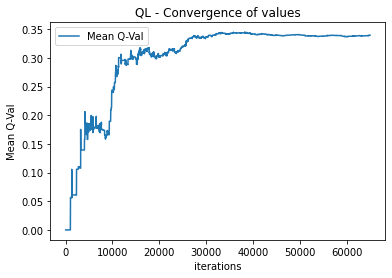

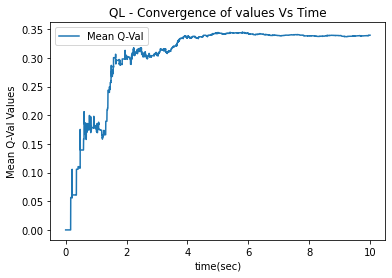

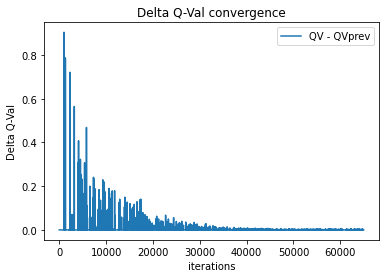

In [6]:
## Convergence - QL
np.random.seed(0)
discount = 0.99
ql = mdp.QLearning(transitions, reward, gamma=discount, 
                        alpha=1.0, alpha_decay=0.9999, alpha_min=0.01,
                        epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.9997,
                        run_stat_frequency=1)
ql.max_iter= 65000
ql.setSilent()
ql.run()


y = [run_stats['Mean V'] for run_stats in ql.run_stats]
plt.xlabel('iterations')
plt.ylabel('Mean Q-Val')
plt.plot(y, label="Mean Q-Val")
plt.legend()
plt.title("QL - Convergence of values")
plt.show()

y = [run_stats['Mean V'] for run_stats in ql.run_stats]
x = [run_stats['Time'] for run_stats in ql.run_stats]
plt.xlabel('time(sec)')
plt.ylabel('Mean Q-Val Values')
plt.plot(x, y, label="Mean Q-Val")
plt.legend()
plt.title("QL - Convergence of values Vs Time")
plt.show()

# Convergence as a function of time
y = [run_stats['Error'] for run_stats in ql.run_stats]
# x = [run_stats['Time'] for run_stats in ql.run_stats]
plt.xlabel('iterations')
plt.ylabel('Delta Q-Val')
plt.plot(y, label="QV - QVprev")
plt.legend()
plt.title("Delta Q-Val convergence")
plt.show()

Text(0.5, 1.0, 'Exploration/Exploitation balance (HyperParam - epsdecay)')

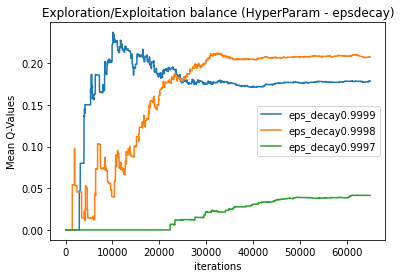

In [7]:
## QL HyperParam tuning
np.random.seed(0)
# plt.figure(figsize=(20,5))
plt.figure()

for decay in [0.9999, 0.9998, 0.9997]:
    discount = 0.97
    ql = mdp.QLearning(transitions, reward, gamma=discount, 
                            alpha=1.0, alpha_decay=0.9999, alpha_min=0.01,
                            epsilon=1.0, epsilon_min=0.1, epsilon_decay=decay,
                            run_stat_frequency=1)

    ql.max_iter= 65000
    ql.setSilent()
    ql.run()

    y = [run_stats['Mean V'] for run_stats in ql.run_stats]
    plt.xlabel('iterations')
    plt.ylabel('Mean Q-Values')
    plt.plot(y, label="eps_decay"+str(decay))
    plt.legend()

plt.title("Exploration/Exploitation balance (HyperParam - epsdecay)")


Text(0.5, 1.0, 'HyperParam - alpha Decay')

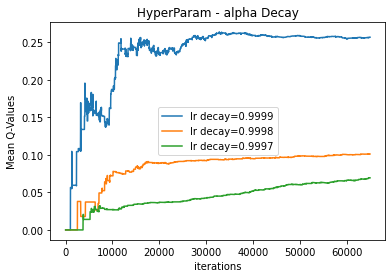

In [8]:
## QL HyperParam tuning
np.random.seed(0)
# plt.figure(figsize=(20,5))
plt.figure()

epsilon_decay = 0.9997
discount = 0.97

for aDecay in [0.9999, 0.9998, 0.9997]:
    ql = mdp.QLearning(transitions, reward, gamma=discount, 
                            alpha=1.0, alpha_decay=aDecay, alpha_min=0.01,
                            epsilon=1.0, epsilon_min=0.1, epsilon_decay=epsilon_decay,
                            run_stat_frequency=1)

    ql.max_iter= 65000
    ql.setSilent()
    ql.run()

    y = [run_stats['Mean V'] for run_stats in ql.run_stats]
    plt.xlabel('iterations')
    plt.ylabel('Mean Q-Values')
    plt.plot(y, label="lr decay="+str(aDecay))
    plt.legend()

plt.title("HyperParam - alpha Decay")


In [9]:
print('discount', discount, 'aDecay', aDecay, 'epsilon_decay', decay)

discount 0.97 aDecay 0.9997 epsilon_decay 0.9997


In [10]:
### QL Optimal Policy Plot
discount = 0.97
aDecay = 0.9999
eps_decay = 0.9997

ql = mdp.QLearning(transitions, reward, gamma=discount, 
                        alpha=1.0, alpha_decay=aDecay, alpha_min=0.01,
                        epsilon=1.0, epsilon_min=0.1, epsilon_decay=eps_decay,
                        run_stat_frequency=1)

ql.max_iter= 65000
ql.setSilent()
ql.run()

ql.policy
render_policy(ql.policy, "QL Policy", holes)

QL Policy
['<', '<', '<', '<']
['<', 'H', '<', 'H']
['^', 'v', '<', 'H']
['H', '>', 'v', 'G']


In [11]:
### Test cell
np.random.seed(0)
discount = 0.97
aDecay = 0.9999
eps_decay = 0.9997

ql = mdp.QLearning(transitions, reward, gamma=discount, 
                        alpha=1.0, alpha_decay=aDecay, alpha_min=0.01,
                        epsilon=1.0, epsilon_min=0.1, epsilon_decay=eps_decay,
                        run_stat_frequency=1)
ql.max_iter= 65000
ql.run()

y = [run_stats['Reward'] for run_stats in ql.run_stats]
print('iterations', len(y), 'Total rewards', np.sum(y))

discount = 0.97
vi = mdp.ValueIteration(transitions, reward, discount, epsilon=0.01, max_iter=5000, initial_value=0, 
                        run_stat_frequency=1)
vi.run()
y = [run_stats['Reward'] for run_stats in vi.run_stats]
print('iterations', len(y), 'Total rewards', np.sum(y))

discount = 0.97
pi = mdp.PolicyIteration(transitions, reward, discount, eval_type=1, max_iter=5000, run_stat_frequency=1)
pi.run()
y = [run_stats['Reward'] for run_stats in vi.run_stats]
print('iterations', len(y), 'Total rewards', np.sum(y))

iterations 65000 Total rewards 166.0
iterations 78 Total rewards 57.52569494950666
iterations 78 Total rewards 57.52569494950666


## VI

Iteration 78
CPU time 0.015252113342285156


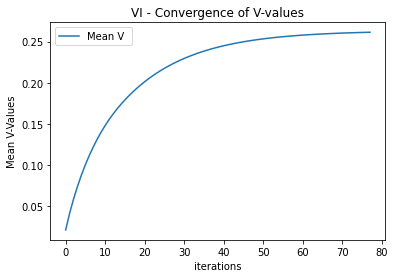

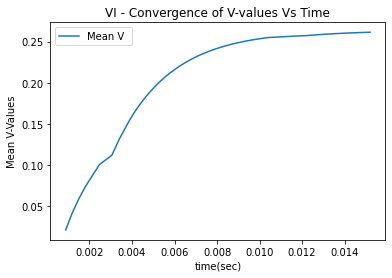

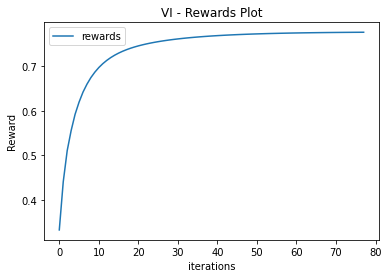

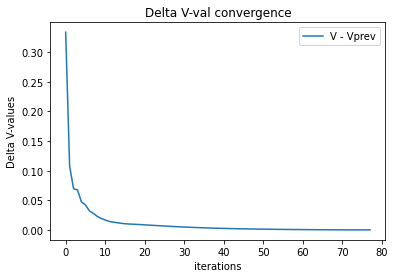

In [12]:
## Convergence - VI policy
discount = 0.97
vi = mdp.ValueIteration(transitions, reward, discount, epsilon=0.01, max_iter=5000, initial_value=0, 
                        run_stat_frequency=1)
# vi.setVerbose()
vi.run()

print("Iteration", vi.iter)
print("CPU time", vi.time)
# print(vi.run_stats[0:])

y = [run_stats['Mean V'] for run_stats in vi.run_stats]
plt.xlabel('iterations')
plt.ylabel('Mean V-Values')
plt.plot(y, label="Mean V ")
plt.legend()
plt.title("VI - Convergence of V-values")
plt.show()

y = [run_stats['Mean V'] for run_stats in vi.run_stats]
x = [run_stats['Time'] for run_stats in vi.run_stats]
plt.xlabel('time(sec)')
plt.ylabel('Mean V-Values')
plt.plot(x, y, label="Mean V ")
plt.legend()
plt.title("VI - Convergence of V-values Vs Time")
plt.show()

y = [run_stats['Reward'] for run_stats in vi.run_stats]
plt.xlabel('iterations')
plt.ylabel('Reward')
plt.plot(y, label="rewards")
plt.legend()
plt.title("VI - Rewards Plot")
plt.show()

# Convergence as a function of time
y = [run_stats['Error'] for run_stats in vi.run_stats]
plt.xlabel('iterations')
plt.ylabel('Delta V-values')
plt.plot(y, label="V - Vprev")
plt.legend()
plt.title("Delta V-val convergence")
plt.show()

In [13]:
## Optimal Policy Plot
discount = 0.98
vi = mdp.ValueIteration(transitions, reward, discount, epsilon=0.01, max_iter=5000, initial_value=0, 
                        run_stat_frequency=1)
vi.run()
render_policy(vi.policy, "VI Policy", holes)

VI Policy
['<', '^', '^', '^']
['<', 'H', '<', 'H']
['^', 'v', '<', 'H']
['H', '>', 'v', 'G']


In [14]:
vi.run_stats[0]

{'State': None,
 'Action': None,
 'Reward': 0.3333333432674408,
 'Error': 0.3333333432674408,
 'Time': 0.0002651214599609375,
 'Max V': 0.3333333432674408,
 'Mean V': 0.02083333395421505,
 'Iteration': 1}

## PI

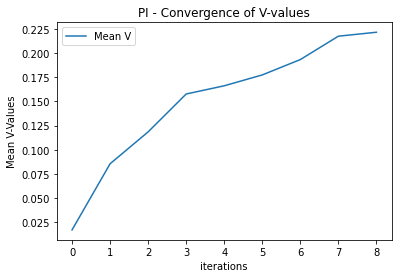

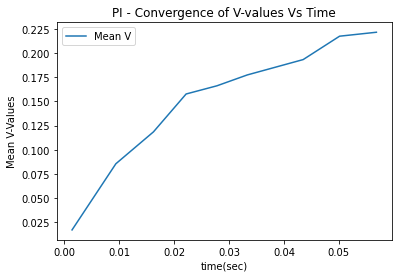

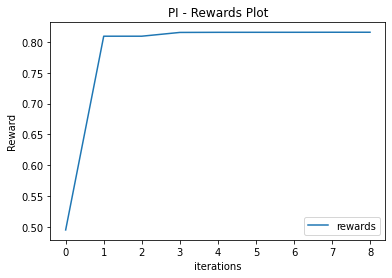

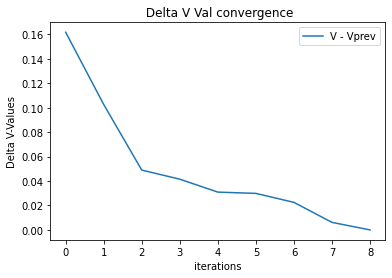

In [26]:
## Convergence PI policy
vi=None
discount = 0.98
pi = mdp.PolicyIteration(transitions, reward, discount, eval_type=1, max_iter=5000, run_stat_frequency=1)
pi.run()

# print("Iteration", pi.iter)
# print("CPU time", pi.time)
# print(vi.run_stats[0:])

y = [run_stats['Mean V'] for run_stats in pi.run_stats]
plt.xticks(range(len(y)))
plt.xlabel('iterations')
plt.ylabel('Mean V-Values')
plt.plot(y, label="Mean V")
plt.legend()
plt.title("PI - Convergence of V-values")
plt.show()

y = [run_stats['Mean V'] for run_stats in pi.run_stats]
x = [run_stats['Time'] for run_stats in pi.run_stats]
plt.xlabel('time(sec)')
plt.ylabel('Mean V-Values')
plt.plot(x, y, label="Mean V")
plt.legend()
plt.title("PI - Convergence of V-values Vs Time")
plt.show()

y = [run_stats['Reward'] for run_stats in pi.run_stats]
plt.xticks(range(len(y)))
plt.xlabel('iterations')
plt.ylabel('Reward')
plt.plot(y, label="rewards")
plt.legend()
plt.title("PI - Rewards Plot")
plt.show()

# Convergence as a function of time
y = [run_stats['Error'] for run_stats in pi.run_stats]
plt.xticks(range(len(y)))
plt.xlabel('iterations')
plt.ylabel('Delta V-Values')
plt.plot(y, label="V - Vprev")
plt.legend()
plt.title(" Delta V Val convergence")
plt.show()

In [16]:
## Optimal Policy Plot
discount = 0.98
pi = mdp.PolicyIteration(transitions, reward, discount, eval_type=1, max_iter=5000, run_stat_frequency=1)
pi.run()
render_policy(pi.policy, "PI Policy", holes)

PI Policy
['<', '^', '^', '^']
['<', 'H', '<', 'H']
['^', 'v', '<', 'H']
['H', '>', 'v', 'G']


#### Varying gamma

In [17]:
print("VI")
for discount in [0.90, 0.92, 0.94, 0.96, 0.98]:
    vi = mdp.ValueIteration(transitions, reward, discount, epsilon=0.01, max_iter=5000, initial_value=0)
#     vi.setVerbose()
    vi.run()
    print("discount", discount, "iter", vi.iter, ", time", vi.time)

print("PI")
for discount in [0.90, 0.92, 0.94, 0.96, 0.98]:
    pi = mdp.PolicyIteration(transitions, reward, discount, eval_type=1, max_iter=5000)
    pi.run()
    print("discount", discount, ", iter", pi.iter, ", time", pi.time)

VI
discount 0.9 iter 26 , time 0.006616830825805664
discount 0.92 iter 33 , time 0.012436866760253906
discount 0.94 iter 44 , time 0.008174896240234375
discount 0.96 iter 63 , time 0.010827064514160156
discount 0.98 iter 111 , time 0.02091693878173828
PI
discount 0.9 , iter 5 , time 0.009794950485229492
discount 0.92 , iter 5 , time 0.005845069885253906
discount 0.94 , iter 5 , time 0.007464170455932617
discount 0.96 , iter 5 , time 0.01789712905883789
discount 0.98 , iter 6 , time 0.015281915664672852


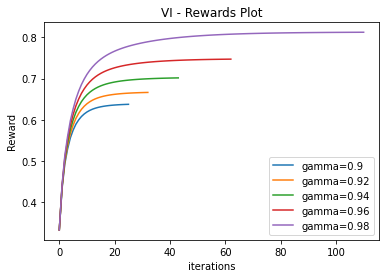

In [18]:
plt.figure()
for discount in [0.90, 0.92, 0.94, 0.96, 0.98]:
    vi = mdp.ValueIteration(transitions, reward, discount, epsilon=0.01, max_iter=5000, initial_value=0)
    vi.run()
    y = [run_stats['Reward'] for run_stats in vi.run_stats]
    plt.xlabel('iterations')
    plt.ylabel('Reward')
    plt.plot(y, label="gamma="+str(discount))
    plt.legend()
    
plt.title("VI - Rewards Plot")
plt.show()

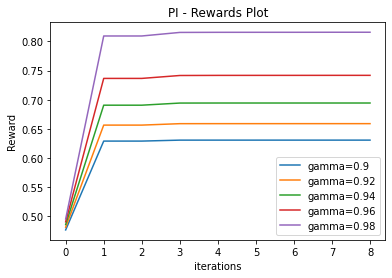

In [28]:
np.random.seed(0)
plt.figure()
for discount in [0.90, 0.92, 0.94, 0.96, 0.98]:
    pi = mdp.PolicyIteration(transitions, reward, discount, eval_type=1, max_iter=5000)
    pi.run()
    y = [run_stats['Reward'] for run_stats in pi.run_stats]
    plt.xlabel('iterations')
    plt.ylabel('Reward')
    plt.plot(y, label="gamma="+str(discount))
    plt.legend()
    
plt.title("PI - Rewards Plot")
plt.show()

In [19]:
## Test cell
discount = 0.9
vi = mdp.ValueIteration(transitions, reward, discount, epsilon=0.01, max_iter=5000, initial_value=0, 
                        run_stat_frequency=1)
vi.run()
render_policy(vi.policy, "VI Policy (gamma=0.9)", holes)

print("")
## Optimal Policy Plot
discount = 0.98
vi = mdp.ValueIteration(transitions, reward, discount, epsilon=0.01, max_iter=5000, initial_value=0, 
                        run_stat_frequency=1)
vi.run()
render_policy(vi.policy, "VI Policy (gamma=0.98)", holes)

VI Policy (gamma=0.9)
['<', '^', '<', '^']
['<', 'H', '<', 'H']
['^', 'v', '<', 'H']
['H', '>', 'v', 'G']

VI Policy (gamma=0.98)
['<', '^', '^', '^']
['<', 'H', '<', 'H']
['^', 'v', '<', 'H']
['H', '>', 'v', 'G']


# FrozenLake 8x8 - study

In [20]:
env = gym.make( 'FrozenLake-v0' , map_name = '8x8' )

env.reset()
env.render()
if not hasattr(env, 'nb_states'):  env.nb_states = env.env.nS
if not hasattr(env, 'nb_actions'): env.nb_actions = env.env.nA
print(env.nb_states, env.nb_actions)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
64 4


In [21]:
#stochastic
# transitions - AxSxS
# reward - AxSxS
transitions = np.zeros(shape=(env.nb_actions, env.nb_states, env.nb_states), dtype=np.float32)
reward = np.zeros(shape=(env.nb_actions, env.nb_states, env.nb_states), dtype=np.float32)

holes = []
for a in range(env.nb_actions):
    for s in range(env.nb_states):
        for i in range(len(env.P[s][a])):
            next_s = env.P[s][a][i][1]
            transitions[a][s][next_s] += env.P[s][a][i][0]
            reward[a][s][next_s] += env.P[s][a][i][2]
            if next_s == s and env.P[s][a][i][3]==True and s not in holes:
                holes.append(s)

## VI

Iteration 99
CPU time 0.020529747009277344


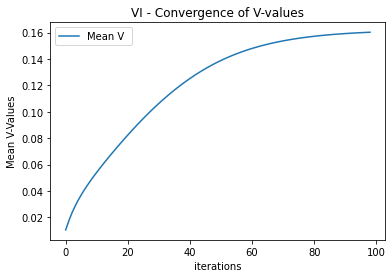

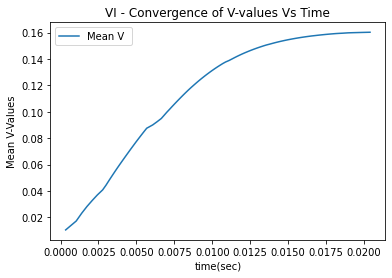

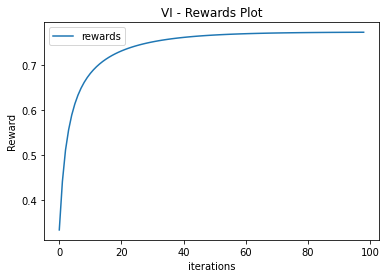

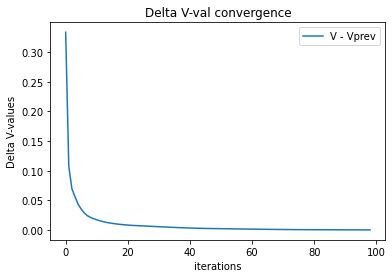

In [22]:
## Convergence - VI policy
discount = 0.97
vi = mdp.ValueIteration(transitions, reward, discount, epsilon=0.01, max_iter=5000, initial_value=0, 
                        run_stat_frequency=1)
# vi.setVerbose()
vi.run()

print("Iteration", vi.iter)
print("CPU time", vi.time)
# print(vi.run_stats[0:])

y = [run_stats['Mean V'] for run_stats in vi.run_stats]
plt.xlabel('iterations')
plt.ylabel('Mean V-Values')
plt.plot(y, label="Mean V ")
plt.legend()
plt.title("VI - Convergence of V-values")
plt.show()

y = [run_stats['Mean V'] for run_stats in vi.run_stats]
x = [run_stats['Time'] for run_stats in vi.run_stats]
plt.xlabel('time(sec)')
plt.ylabel('Mean V-Values')
plt.plot(x, y, label="Mean V ")
plt.legend()
plt.title("VI - Convergence of V-values Vs Time")
plt.show()

y = [run_stats['Reward'] for run_stats in vi.run_stats]
plt.xlabel('iterations')
plt.ylabel('Reward')
plt.plot(y, label="rewards")
plt.legend()
plt.title("VI - Rewards Plot")
plt.show()

# Convergence as a function of time
y = [run_stats['Error'] for run_stats in vi.run_stats]
plt.xlabel('iterations')
plt.ylabel('Delta V-values')
plt.plot(y, label="V - Vprev")
plt.legend()
plt.title("Delta V-val convergence")
plt.show()

In [23]:
## Optimal Policy Plot
discount = 0.97
vi = mdp.ValueIteration(transitions, reward, discount, epsilon=0.01, max_iter=5000, initial_value=0, 
                        run_stat_frequency=1)
vi.run()
render_policy(vi.policy, "VI Policy", holes, NUM_COLS=8, NUM_ROWS=8)

VI Policy
['^', '>', '>', '>', '>', '>', '>', '>']
['^', '^', '^', '^', '>', '>', '>', 'v']
['^', '^', '<', 'H', '>', '^', '>', 'v']
['^', '^', '^', 'v', '<', 'H', '>', 'v']
['^', '^', '<', 'H', '>', 'v', '^', '>']
['<', 'H', 'H', 'v', '^', '<', 'H', '>']
['<', 'H', 'v', '<', 'H', '<', 'H', '>']
['<', 'v', '<', 'H', 'v', 'v', 'v', 'G']


## QL

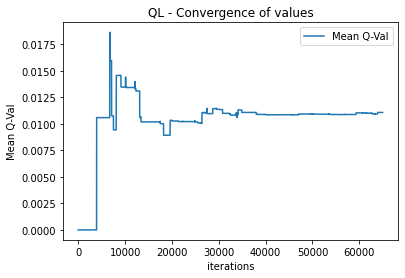

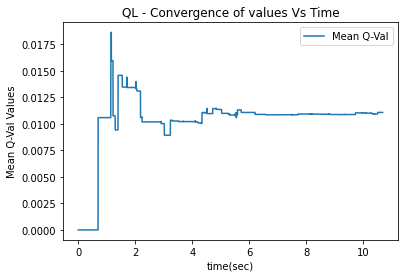

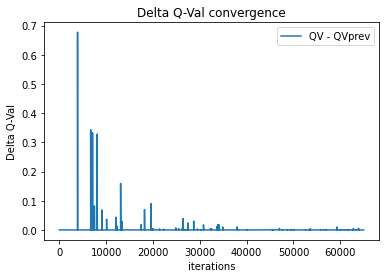

In [24]:
## Convergence - QL
np.random.seed(0)
discount = 0.99
ql = mdp.QLearning(transitions, reward, gamma=discount, 
                        alpha=1.0, alpha_decay=0.9999, alpha_min=0.01,
                        epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.9997,
                        run_stat_frequency=1)
ql.max_iter= 65000
ql.setSilent()
ql.run()


y = [run_stats['Mean V'] for run_stats in ql.run_stats]
plt.xlabel('iterations')
plt.ylabel('Mean Q-Val')
plt.plot(y, label="Mean Q-Val")
plt.legend()
plt.title("QL - Convergence of values")
plt.show()

y = [run_stats['Mean V'] for run_stats in ql.run_stats]
x = [run_stats['Time'] for run_stats in ql.run_stats]
plt.xlabel('time(sec)')
plt.ylabel('Mean Q-Val Values')
plt.plot(x, y, label="Mean Q-Val")
plt.legend()
plt.title("QL - Convergence of values Vs Time")
plt.show()

# Convergence as a function of time
y = [run_stats['Error'] for run_stats in ql.run_stats]
# x = [run_stats['Time'] for run_stats in ql.run_stats]
plt.xlabel('iterations')
plt.ylabel('Delta Q-Val')
plt.plot(y, label="QV - QVprev")
plt.legend()
plt.title("Delta Q-Val convergence")
plt.show()

In [25]:
### QL Optimal Policy Plot
discount = 0.97
aDecay = 0.9999
eps_decay = 0.9997

ql = mdp.QLearning(transitions, reward, gamma=discount, 
                        alpha=1.0, alpha_decay=aDecay, alpha_min=0.01,
                        epsilon=1.0, epsilon_min=0.1, epsilon_decay=eps_decay,
                        run_stat_frequency=1)

ql.max_iter= 65000
ql.setSilent()
ql.run()

ql.policy
render_policy(ql.policy, "QL Policy", holes, NUM_COLS=8, NUM_ROWS=8)

QL Policy
['<', '<', '<', '<', '<', 'v', '>', '<']
['<', '<', '<', '<', '<', '>', '<', '<']
['<', '<', '<', 'H', '<', '<', '^', '<']
['<', '<', '<', '<', '<', 'H', '<', '<']
['<', '<', '<', 'H', '<', '<', '>', '<']
['<', 'H', 'H', '<', '<', '<', 'H', '<']
['<', 'H', '<', '<', 'H', '<', 'H', '<']
['<', '<', '<', 'H', '<', '<', '<', 'G']
